#[01] Pipeline Sentiment Analysis

In [ ]:
!pip install transformers

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-06-25 13:10:40--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‚ÄòAirlineTweets.csv‚Äô

AirlineTweets.csv   100%[===================>]   3.26M  --.-KB/s    in 0.06s   

2024-06-25 13:10:40 (52.4 MB/s) - ‚ÄòAirlineTweets.csv‚Äô saved [3421431/3421431]



In [ ]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# Basic usage
classifier = pipeline("sentiment-analysis")

type(classifier)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that aut

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

transformers.pipelines.text_classification.TextClassificationPipeline

In [ ]:
# Output is a dictionary
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

In [ ]:
classifier("This show was not interesting")

[{'label': 'NEGATIVE', 'score': 0.9997871518135071}]

In [ ]:
classifier("This show was interesting")

[{'label': 'POSITIVE', 'score': 0.999747097492218}]

In [ ]:
classifier("This show was not bad at all")

[{'label': 'POSITIVE', 'score': 0.998742401599884}]

In [ ]:
classifier("I can't say that this was a good movie")

[{'label': 'NEGATIVE', 'score': 0.9278444051742554}]

In [ ]:
# Multiple inputs passed in as a list
classifier([
    "This course is just what I needed.",
    "I can't understand any of this. Instructor kept telling me to meet the \
    prerequisites. What are prerequisites? Why does he keep saying that?"
])

[{'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9966675639152527}]

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
torch.cuda.current_device()

0

In [ ]:
# Use the GPU
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
df_ = pd.read_csv('AirlineTweets.csv')

df_.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

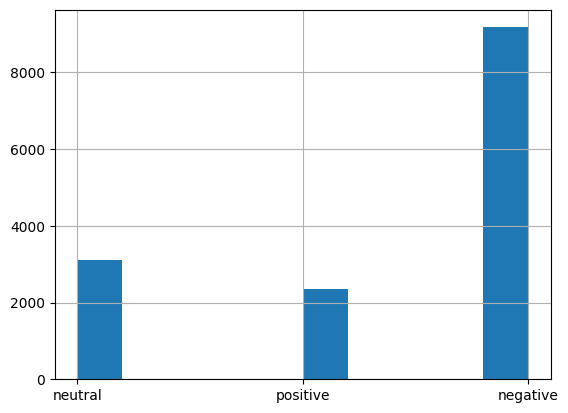

In [ ]:
df = df_[['airline_sentiment', 'text']].copy()

df['airline_sentiment'].hist();

In [ ]:
df = df[df.airline_sentiment != 'neutral'].copy()

df

airline_sentiment                                               text
1              positive  @VirginAmerica plus you've added commercials t...
3              negative  @VirginAmerica it's really aggressive to blast...
4              negative  @VirginAmerica and it's a really big bad thing...
5              negative  @VirginAmerica seriously would pay $30 a fligh...
6              positive  @VirginAmerica yes, nearly every time I fly VX...
...                 ...                                                ...
14633          negative  @AmericanAir my flight was Cancelled Flightled...
14634          negative         @AmericanAir right on cue with the delaysüëå
14635          positive  @AmericanAir thank you we got on a different f...
14636          negative  @AmericanAir leaving over 20 minutes Late Flig...
14638          negative  @AmericanAir you have my money, you change my ...

[11541 rows x 2 columns]

In [ ]:
target_map = {'positive':1, "negative":0}
df['target'] = df['airline_sentiment'].map(target_map)

df.head()

airline_sentiment                                               text  target
1          positive  @VirginAmerica plus you've added commercials t...       1
3          negative  @VirginAmerica it's really aggressive to blast...       0
4          negative  @VirginAmerica and it's a really big bad thing...       0
5          negative  @VirginAmerica seriously would pay $30 a fligh...       0
6          positive  @VirginAmerica yes, nearly every time I fly VX...       1

In [ ]:
len(df)

11541

In [ ]:
texts = df['text'].tolist()
predictions = classifier(texts)

predictions

[{'label': 'POSITIVE', 'score': 0.6070822477340698},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553213715553284},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

In [ ]:
probs = [d['score'] if d['label'].startswith('P') else 1 - d['score'] for d in predictions]

probs

[0.6070822477340698,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553213715553284,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787647724151611,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.00040477514266967773,
 0.0006322264671325684,
 0.015428304672241211,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934480786323547,
 0.9976067543029785,
 0.8661710023880005,
 0.0003237724304199219,
 0.8415611982345581,
 0.0032317638397216797,
 0.9997846484184265,
 0.1761440634727478,
 0.9993895292282104,
 0.09156644344329834,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.991169810295105,
 0.01255035400390625,
 0.00809931755065918,
 0.9

In [ ]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]

preds = np.array(preds)

print("acc:", np.mean(df['target'] == preds))

acc: 0.8898708950697514


In [ ]:
cm = confusion_matrix(df['target'], preds, normalize='true')

cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

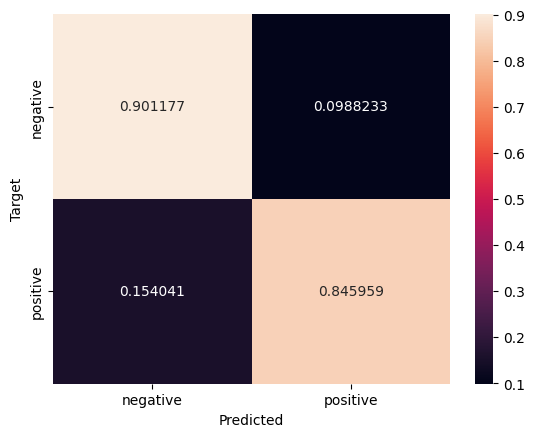

In [ ]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Target')

plot_cm(cm);

In [ ]:
f1_score(df['target'], preds)

0.7587777566900741

In [ ]:
f1_score(1 - df['target'], 1 - preds)

0.928647616908999

In [ ]:
roc_auc_score(df['target'], probs)

0.9485934460102434

In [ ]:
roc_auc_score(1 - df['target'], 1 - np.array(probs))

0.9485934460102434

#[02] Pipeline Text Generation

In [ ]:
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

--2024-06-27 07:33:25--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56286 (55K) [text/plain]
Saving to: ‚Äòrobert_frost.txt‚Äô

robert_frost.txt    100%[===================>]  54.97K  --.-KB/s    in 0.002s  

2024-06-27 07:33:25 (30.6 MB/s) - ‚Äòrobert_frost.txt‚Äô saved [56286/56286]



In [ ]:
from transformers import pipeline, set_seed

import textwrap
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

In [ ]:
!cat robert_frost.txt

Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth; 

Then took the other, as just as fair,
And having perhaps the better claim
Because it was grassy and wanted wear,
Though as for that the passing there
Had worn them really about the same,

And both that morning equally lay
In leaves no step had trodden black.
Oh, I kept the first for another day! 
Yet knowing how way leads on to way
I doubted if I should ever come back.

I shall be telling this with a sigh
Somewhere ages and ages hence:
Two roads diverged in a wood, and I,
I took the one less traveled by,
And that has made all the difference.

Whose woods these are I think I know.
His house is in the village, though; 
He will not see me stopping here
To watch his woods fill up with snow.

My little horse must think it queer
To stop without a farmhouse near
Between the woods and frozen lake
The darkest evenin

In [ ]:
lines = [line.rstrip() for line in open('robert_frost.txt')]
lines = [line for line in lines if len(line) > 0]

In [ ]:
lines[0]

'Two roads diverged in a yellow wood,'

In [ ]:
gen = pipeline("text-generation")

set_seed(1234)

gen(lines[0])

No model was supplied, defaulted to openai-community/gpt2 and revision 6c0e608 (https://huggingface.co/openai-community/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or d

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Two roads diverged in a yellow wood, which they had left behind a few yards from where they had cut from. At the end of the road stood a tall red pole and, just out of view, the white-lipped man could see'}]

In [ ]:
pprint(_)

[{'generated_text': 'Two roads diverged in a yellow wood, which they had left '
                    'behind a few yards from where they had cut from. At the '
                    'end of the road stood a tall red pole and, just out of '
                    'view, the white-lipped man could see'}]


In [ ]:
pprint(gen(lines[0], max_length=20))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Two roads diverged in a yellow wood, and each turned into '
                    'a narrow black hole. It became'}]


In [ ]:
pprint(gen(lines[0], num_return_sequences=3, max_length=20))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Two roads diverged in a yellow wood, which was called the '
                    'A-track, and three separate'},
 {'generated_text': 'Two roads diverged in a yellow wood, the trees growing '
                    'between. On one side, the trees'},
 {'generated_text': 'Two roads diverged in a yellow wood, some were blocked by '
                    'the road to the right and one'}]


In [ ]:
def wrap(x):
    return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

out = gen(lines[0], max_length=30)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two roads diverged in a yellow wood, leaving a trail of boulders and
vines.  All were in the right of the road, and a small


In [ ]:
out = gen(lines[0], max_length=30)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two roads diverged in a yellow wood, which turned out to be a small,
narrow road that runs along a portion of the road.  It's


In [ ]:
prev = "Two roads dieverged in a yellow wood, including one that blocked the" + \
" road leading to another intersection in the middle of the city."

out = gen(prev + '\n' + lines[2], max_length=60)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two roads dieverged in a yellow wood, including one that blocked the
road leading to another intersection in the middle of the city.
And be
one traveler, long I stood in line, waiting in the streets and cars,
and in front of mine, there stood the city, a thousand times


In [ ]:
prev = "Two roads diverged in a yellow wood, including one that blocked the" + \
" road leading to another intersection in the middle of the city.\n" + \
"And be one traveler, long I stood in front of the burning weckage. " + \
"That's what I had written on Twitter a few minutes ago."

out = gen(prev + '\n' + lines[4], max_length=90)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two roads diverged in a yellow wood, including one that blocked the
road leading to another intersection in the middle of the city.
And be
one traveler, long I stood in front of the burning weckage.  That's
what I had written on Twitter a few minutes ago.
To where it bent in
the undergrowth; a stone wall, about 50 feet high and 20 feet wide,
came to rest against a stone puddle full of


In [ ]:
prompt = "Neural networks with attention have been used with gread success" + \
" in natural language processing."

out = gen(prompt, max_length=300)
print(wrap(out[0]['generated_text']))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Neural networks with attention have been used with gread success in
natural language processing.  But as researchers at UCLA think they
can design gread-based neural networks, researchers will have to
figure out how those neural networks work in real-world tasks as well.
If the researchers ever get good at developing gread circuits, their
technology will help create a neural network capable of learning and
learning from a given situation.

The neural networks are built on two
primary components ‚Äì a high-dimensional network that shows where it
takes a sentence and a contextual context and a low-dimensional
network that shows where the word is placed at key moments (i.e., is
it relevant) and then a deep network that doesn't move and has to
learn a new word by doing the same.

These networks use a process
called 'deep learning' to learn from a given situation, and then try
to learn a word if it makes sense.  At first, the network learns a
sentence a certain way from an earlier stage of 

#[03] Masked Language Modeling

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-06-27 08:06:30--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‚Äòbbc_text_cls.csv‚Äô

bbc_text_cls.csv    100%[===================>]   4.85M  4.87MB/s    in 1.0s    

2024-06-27 08:06:32 (4.87 MB/s) - ‚Äòbbc_text_cls.csv‚Äô saved [5085081/5085081]



In [ ]:
import numpy as np
import pandas as pd
import textwrap
from pprint import pprint

from transformers import pipeline

In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

df.head()

text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business

In [ ]:
labels = set(df['labels'])
labels

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [ ]:
# Pick a label
label = "business"

texts = df[df['labels'] == label]['text']
texts.head()

0    Ad sales boost Time Warner profit\n\nQuarterly...
1    Dollar gains on Greenspan speech\n\nThe dollar...
2    Yukos unit buyer faces loan claim\n\nThe owner...
3    High fuel prices hit BA's profits\n\nBritish A...
4    Pernod takeover talk lifts Domecq\n\nShares in...
Name: text, dtype: object

In [ ]:
np.random.seed(1234)

In [ ]:
i = np.random.choice(texts.shape[0])
doc = texts.iloc[i]

print(textwrap.fill(doc, replace_whitespace=False, fix_sentence_endings=True))

Bombardier chief to leave company

Shares in train and plane-making
giant Bombardier have fallen to a 10-year low following the departure
of its chief executive and two members of the board.

Paul Tellier,
who was also Bombardier's president, left the company amid an ongoing
restructuring.  Laurent Beaudoin, part of the family that controls the
Montreal-based firm, will take on the role of CEO under a newly
created management structure.  Analysts said the resignations seem to
have stemmed from a boardroom dispute.  Under Mr Tellier's tenure at
the company, which began in January 2003, plans to cut the worldwide
workforce of 75,000 by almost a third by 2006 were announced.  The
firm's snowmobile division and defence services unit were also sold
and Bombardier started the development of a new aircraft seating 110
to 135 passengers.

Mr Tellier had indicated he wanted to stay at the
world's top train maker and third largest manufacturer of civil
aircraft until the restructuring was comple

In [ ]:
mlm = pipeline("fill-mask")

No model was supplied, defaulted to distilbert/distilroberta-base and revision ec58a5b (https://huggingface.co/distilbert/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
mlm("Bombvardier chief to leave <mask>")

[{'score': 0.06466620415449142,
  'token': 633,
  'token_str': ' job',
  'sequence': 'Bombvardier chief to leave job'},
 {'score': 0.04728004336357117,
  'token': 558,
  'token_str': ' office',
  'sequence': 'Bombvardier chief to leave office'},
 {'score': 0.03153010085225105,
  'token': 20283,
  'token_str': ' NYPD',
  'sequence': 'Bombvardier chief to leave NYPD'},
 {'score': 0.0287413839250803,
  'token': 618,
  'token_str': ' post',
  'sequence': 'Bombvardier chief to leave post'},
 {'score': 0.021987346932291985,
  'token': 1470,
  'token_str': ' France',
  'sequence': 'Bombvardier chief to leave France'}]

In [ ]:
text = "Shares in <mask> and plane-making " + \
"giant Bombardier have fallen to a 10-year low following the departure " + \
"of its chief executive and two members of the board."

mlm(text)

[{'score': 0.6640910506248474,
  'token': 11016,
  'token_str': ' Airbus',
  'sequence': 'Shares in Airbus and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.2614683508872986,
  'token': 6722,
  'token_str': ' Boeing',
  'sequence': 'Shares in Boeing and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.02363520674407482,
  'token': 15064,
  'token_str': ' aerospace',
  'sequence': 'Shares in aerospace and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the board.'},
 {'score': 0.014581655152142048,
  'token': 8537,
  'token_str': ' airlines',
  'sequence': 'Shares in airlines and plane-making giant Bombardier have fallen to a 10-year low following the departure of its chief executive and two members of the

#[04] Named Entity Recognition (NER)

In [ ]:
from transformers import pipeline

ner = pipeline("ner", aggregation_strategy='simple', device=0)

import pickle

# conll 2003
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recom

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

--2024-06-27 08:22:09--  https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4757208 (4.5M) [application/octet-stream]
Saving to: ‚Äòner_train.pkl‚Äô

ner_train.pkl       100%[===================>]   4.54M  --.-KB/s    in 0.09s   

2024-06-27 08:22:09 (49.8 MB/s) - ‚Äòner_train.pkl‚Äô saved [4757208/4757208]

--2024-06-27 08:22:09--  https://lazyprogrammer.me/course_files/nlp/ner_test.pkl
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201978 (1.1M) [application/octet-stream]
Saving to: ‚Äòner_test.pkl‚Äô

ner_test.pkl        10

In [ ]:
with open('ner_train.pkl', 'rb') as f:
    corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as f:
    corpus_test = pickle.load(f)

In [ ]:
corpus_test

[[('CRICKET', 'O'),
  ('-', 'O'),
  ('LEICESTERSHIRE', 'B-ORG'),
  ('TAKE', 'O'),
  ('OVER', 'O'),
  ('AT', 'O'),
  ('TOP', 'O'),
  ('AFTER', 'O'),
  ('INNINGS', 'O'),
  ('VICTORY', 'O'),
  ('.', 'O')],
 [('West', 'B-MISC'),
  ('Indian', 'I-MISC'),
  ('all-rounder', 'O'),
  ('Phil', 'B-PER'),
  ('Simmons', 'I-PER'),
  ('took', 'O'),
  ('four', 'O'),
  ('for', 'O'),
  ('38', 'O'),
  ('on', 'O'),
  ('Friday', 'O'),
  ('as', 'O'),
  ('Leicestershire', 'B-ORG'),
  ('beat', 'O'),
  ('Somerset', 'B-ORG'),
  ('by', 'O'),
  ('an', 'O'),
  ('innings', 'O'),
  ('and', 'O'),
  ('39', 'O'),
  ('runs', 'O'),
  ('in', 'O'),
  ('two', 'O'),
  ('days', 'O'),
  ('to', 'O'),
  ('take', 'O'),
  ('over', 'O'),
  ('at', 'O'),
  ('the', 'O'),
  ('head', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('county', 'O'),
  ('championship', 'O'),
  ('.', 'O')],
 [('Their', 'O'),
  ('stay', 'O'),
  ('on', 'O'),
  ('top', 'O'),
  (',', 'O'),
  ('though', 'O'),
  (',', 'O'),
  ('may', 'O'),
  ('be', 'O'),
  ('short-lived', 

In [ ]:
inputs = []
targets = []

for sentence_tag_pairs in corpus_test:
    tokens = []
    target = []
    for token, tag in sentence_tag_pairs:
        tokens.append(token)
        target.append(tag)

    inputs.append(tokens)
    targets.append(target)

In [ ]:
print(inputs[9])

['He', 'was', 'well', 'backed', 'by', 'England', 'hopeful', 'Mark', 'Butcher', 'who', 'made', '70', 'as', 'Surrey', 'closed', 'on', '429', 'for', 'seven', ',', 'a', 'lead', 'of', '234', '.']


In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenizer = TreebankWordDetokenizer()

detokenizer.detokenize(inputs[9])

'He was well backed by England hopeful Mark Butcher who made 70 as Surrey closed on 429 for seven, a lead of 234.'

In [ ]:
print(targets[9])

['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
ner(detokenizer.detokenize(inputs[9]))

[{'entity_group': 'LOC',
  'score': 0.99967515,
  'word': 'England',
  'start': 22,
  'end': 29},
 {'entity_group': 'PER',
  'score': 0.99974275,
  'word': 'Mark Butcher',
  'start': 38,
  'end': 50},
 {'entity_group': 'ORG',
  'score': 0.9996264,
  'word': 'Surrey',
  'start': 66,
  'end': 72}]

#[05] Text Summarization

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-06-27 09:37:46--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‚Äòbbc_text_cls.csv‚Äô

bbc_text_cls.csv    100%[===================>]   4.85M  --.-KB/s    in 0.06s   

2024-06-27 09:37:46 (87.3 MB/s) - ‚Äòbbc_text_cls.csv‚Äô saved [5085081/5085081]



In [ ]:
import pandas as pd
import numpy as np
import textwrap
from transformers import pipeline

df = pd.read_csv('bbc_text_cls.csv')

df.head()

text    labels
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business

In [ ]:
doc = df[df.labels == 'business']['text'].sample(random_state=42)

In [ ]:
def wrap(x):
    return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

In [ ]:
print(wrap(doc.iloc[0]))

Christmas sales worst since 1981

UK retail sales fell in December,
failing to meet expectations and making it by some counts the worst
Christmas since 1981.

Retail sales dropped by 1% on the month in
December, after a 0.6% rise in November, the Office for National
Statistics (ONS) said.  The ONS revised the annual 2004 rate of growth
down from the 5.9% estimated in November to 3.2%. A number of
retailers have already reported poor figures for December.  Clothing
retailers and non-specialist stores were the worst hit with only
internet retailers showing any significant growth, according to the
ONS.

The last time retailers endured a tougher Christmas was 23 years
previously, when sales plunged 1.7%.

The ONS echoed an earlier
caution from Bank of England governor Mervyn King not to read too much
into the poor December figures.  Some analysts put a positive gloss on
the figures, pointing out that the non-seasonally-adjusted figures
showed a performance comparable with 2003. The Novembe

In [ ]:
summarizer = pipeline("summarization")

summarizer(doc.iloc[0].split("\n", 1)[1])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

[{'summary_text': ' Retail sales dropped by 1% on the month in December, after a 0.6% rise in November . Clothing retailers and non-specialist stores were the worst hit with only internet retailers showing any significant growth . The last time retailers endured a tougher Christmas was 23 years ago, when sales plunged 1.7% .'}]

In [ ]:
def print_summary(doc):
    result = summarizer(doc.iloc[0].split("\n", 1)[1])
    print(wrap(result[0]['summary_text']))

print_summary(doc)

 Retail sales dropped by 1% on the month in December, after a 0.6%
rise in November . Clothing retailers and non-specialist stores were
the worst hit with only internet retailers showing any significant
growth . The last time retailers endured a tougher Christmas was 23
years ago, when sales plunged 1.7% .


In [ ]:
doc = df[df.labels =='entertainment']['text'].sample(random_state=123)
print(wrap(doc.iloc[0]))

Goodrem wins top female MTV prize

Pop singer Delta Goodrem has
scooped one of the top individual prizes at the first Australian MTV
Music Awards.

The 21-year-old singer won the award for best female
artist, with Australian Idol runner-up Shannon Noll taking the title
of best male at the ceremony.  Goodrem, known in both Britain and
Australia for her role as Nina Tucker in TV soap Neighbours, also
performed a duet with boyfriend Brian McFadden.  Other winners
included Green Day, voted best group, and the Black Eyed Peas.
Goodrem, Green Day and the Black Eyed Peas took home two awards each.
As well as best female, Goodrem also took home the Pepsi Viewers
Choice Award, whilst Green Day bagged the prize for best rock video
for American Idiot.  The Black Eyed Peas won awards for best R 'n' B
video and sexiest video, both for Hey Mama.  Local singer and
songwriter Missy Higgins took the title of breakthrough artist of the
year, with Australian Idol winner Guy Sebastian taking the honours f

In [ ]:
print_summary(doc)

 The 21-year-old singer won the award for best female artist .
Australian Idol runner-up Shannon Noll took the title of best male at
the ceremony . Other winners included Green Day, the Black Eyed Peas,
Missy Higgins and Green Day . The VH1 First Music Award went to Cher
honouring her achievements within the music industry .


#[06] Neural Machine Translation

In [ ]:
!wget -nc http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

--2024-06-27 09:52:16--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‚Äòspa-eng.zip‚Äô

spa-eng.zip         100%[===================>]   2.52M  2.13MB/s    in 1.2s    

2024-06-27 09:52:17 (2.13 MB/s) - ‚Äòspa-eng.zip‚Äô saved [2638744/2638744]



In [ ]:
!unzip -nq spa-eng.zip

In [ ]:
!ls

sample_data  spa-eng  spa-eng.zip


In [ ]:
ls spa-eng

_about.txt  spa.txt


In [ ]:
!head spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	V√°yase.
Hi.	Hola.
Run!	¬°Corre!
Run.	Corred.
Who?	¬øQui√©n?
Fire!	¬°Fuego!
Fire!	¬°Incendio!


In [ ]:
# compile eng-spa translations
eng2spa = {}
for line in open('spa-eng/spa.txt'):
    line = line.rstrip()
    eng, spa = line.split('\t')
    if eng not in eng2spa:
        eng2spa[eng] = []
    eng2spa[eng].append(spa)

In [ ]:
eng2spa

{'Go.': ['Ve.', 'Vete.', 'Vaya.', 'V√°yase.'],
 'Hi.': ['Hola.'],
 'Run!': ['¬°Corre!'],
 'Run.': ['Corred.'],
 'Who?': ['¬øQui√©n?'],
 'Fire!': ['¬°Fuego!', '¬°Incendio!', '¬°Disparad!'],
 'Help!': ['¬°Ayuda!', '¬°Socorro! ¬°Auxilio!', '¬°Auxilio!'],
 'Jump!': ['¬°Salta!'],
 'Jump.': ['Salte.'],
 'Stop!': ['¬°Parad!', '¬°Para!', '¬°Pare!'],
 'Wait!': ['¬°Espera!'],
 'Wait.': ['Esperen.'],
 'Go on.': ['Contin√∫a.', 'Contin√∫e.'],
 'Hello!': ['Hola.'],
 'I ran.': ['Corr√≠.', 'Corr√≠a.'],
 'I try.': ['Lo intento.'],
 'I won!': ['¬°He ganado!'],
 'Oh no!': ['¬°Oh, no!'],
 'Relax.': ['Tom√°telo con soda.'],
 'Smile.': ['Sonr√≠e.'],
 'Attack!': ['¬°Al ataque!', '¬°Atacad!'],
 'Get up.': ['Levanta.'],
 'Go now.': ['Ve ahora mismo.'],
 'Got it!': ['¬°Lo tengo!'],
 'Got it?': ['¬øLo pillas?', '¬øEntendiste?'],
 'He ran.': ['√âl corri√≥.'],
 'Hop in.': ['M√©tete adentro.'],
 'Hug me.': ['Abr√°zame.'],
 'I fell.': ['Me ca√≠.'],
 'I know.': ['Yo lo s√©.'],
 'I left.': ['Sal√≠.'],
 'I lied.': ['Me

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import RegexpTokenizer

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

tokenizer.tokenize('¬øFue divertido?'.lower())

['fue', 'divertido']

In [ ]:
tokens = tokenizer.tokenize('¬øFue divertido?'.lower())
sentence_bleu([tokens], tokens)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1.491668146240062e-154

In [ ]:
sentence_bleu([['hi']], ['hi'])

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

1.821831989445342e-231

In [ ]:
smoother = SmoothingFunction()
sentence_bleu(['hi'], 'hi', smoothing_function=smoother.method4)

0.2213885886251307

In [ ]:
sentence_bleu([[1,2,3,4]], [1,2,3,4])

1.0

In [ ]:
eng2spa_tokens = {}
for eng, spa_list in eng2spa.items():
    spa_list_tokens = []
    for text in spa_list:
        tokens = tokenizer.tokenize(text.lower())
        spa_list_tokens.append(tokens)
    eng2spa_tokens[eng] = spa_list_tokens

In [ ]:
!pip install transformers sentencepiece transformers[sentencepiece]

In [ ]:
from transformers import pipeline
translator = pipeline("translation", model = 'Helsinki-NLP/opus-mt-en-es', device=0)

translator("I like eggs and ham")

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'Me gustan los huevos y el jam√≥n.'}]

In [ ]:
eng_phrases = list(eng2spa.keys())
len(eng_phrases)

102904

In [ ]:
eng_phrases_subset = eng_phrases[20_000:21_000]

# 27 min for 10k phrases on GPU
translations = translator(eng_phrases_subset)

In [ ]:
translations[0]

In [ ]:
scores = []
for eng, pred in zip(eng_phrases_subset, translations):
    matches = eng2spa_tokens[eng]

    # tokenize translation
    spa_pred = tokenizer.tokenize(pred['translation_text'].lower())

    score = sentence_bleu(matches, spa_pred)
    scores.append(score)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(scores, bins=50);

In [ ]:
import numpy as np
np.mean(scores)

In [ ]:
np.random.seed(1)

def print_random_translation():
    i = np.random.choice(len(eng_phrases_subset))
    eng = eng_phrases_subset[i]
    print("EN:", eng)

    translation = translations[i]['translation_text']
    print("ES Translation:", translation)

    matches = eng2spa[eng]
    print("Matches:", matches)

In [ ]:
print_random_translation()

#[07] Question Answering

In [ ]:
from transformers import pipeline

qa = pipeline("question-answering")

context = "Today I went to the store to purchase a carton of milk."
question = "What did I buy?"

qa(context=context, question=question)

context[38:54]

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recom

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

'a carton of milk'

In [ ]:
qa(context=context, question=question)

{'score': 0.5626214742660522,
 'start': 38,
 'end': 54,
 'answer': 'a carton of milk'}

In [ ]:
context = "Out of all the colors, I like blue the best."
question = "What is my favorite color?"
qa(context=context, question=question)

{'score': 0.9958471059799194, 'start': 30, 'end': 34, 'answer': 'blue'}

In [ ]:
context = "Albert Einstein (14 March 1879 - 18 April 1955) was a " + \
"German-born theoretical physicist, widely acknowledged to be one of the " + \
"greatest physicists of all time. Einstein is best known for developing " + \
"the theory of relativity, but he also made important contributions to " + \
"the development of the theory of quantum mechanics. Relativity and " + \
"quantum mechanics are together the two pillars of modern physics."

question = "When was Albert Einstein born?"

qa(context=context, question=question)

{'score': 0.9411640167236328,
 'start': 17,
 'end': 30,
 'answer': '14 March 1879'}

In [ ]:
question = "What was Albert Einstein's occupation?"
qa(context=context, question=question)

{'score': 0.9530766606330872,
 'start': 66,
 'end': 87,
 'answer': 'theoretical physicist'}

In [ ]:
question = "What is Albert Einstein best known for?"
qa(context=context, question=question)

{'score': 0.8472647070884705,
 'start': 186,
 'end': 221,
 'answer': 'developing the theory of relativity'}

In [ ]:
question = "What else has Albert Einstein contributed to?"
qa(context=context, question=question)

{'score': 0.2840743362903595,
 'start': 290,
 'end': 317,
 'answer': 'theory of quantum mechanics'}

In [ ]:
question = "What are the two pillars of modern physics?"
qa(context=context, question=question)

{'score': 0.9952598214149475,
 'start': 319,
 'end': 351,
 'answer': 'Relativity and quantum mechanics'}

In [ ]:
question = "Where was Albert Einstein born?"
qa(context=context, question=question)

{'score': 0.9950061440467834, 'start': 54, 'end': 60, 'answer': 'German'}

In [ ]:
question = "What is peanut butter made of?"
qa(context=context, question=question)

{'score': 0.0023693654220551252,
 'start': 0,
 'end': 15,
 'answer': 'Albert Einstein'}

#[08] Zero-Shot Classification

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-06-27 13:50:45--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‚Äòbbc_text_cls.csv‚Äô

bbc_text_cls.csv    100%[===================>]   4.85M  4.48MB/s    in 1.1s    

2024-06-27 13:50:48 (4.48 MB/s) - ‚Äòbbc_text_cls.csv‚Äô saved [5085081/5085081]



In [ ]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import textwrap

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [ ]:
classifier = pipeline("zero-shot-classification", device=0)

classifier("This is a great movie", candidate_labels=["positive", "negative"])

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'sequence': 'This is a great movie',
 'labels': ['positive', 'negative'],
 'scores': [0.9969461560249329, 0.0030538293067365885]}

In [ ]:
text = "Due to the presence of isoforms of its components, there are 12 " + \
"versions of AMPK in mammals, each of which can have different tissue " + \
"localizations, and different functions under different conditions. " + \
"AMPK is regulated allosterically and by post-translational " + \
"modification, which work together."

classifier(text, candidate_labels=["biology", "math", "geology"])

{'sequence': 'Due to the presence of isoforms of its components, there are 12 versions of AMPK in mammals, each of which can have different tissue localizations, and different functions under different conditions. AMPK is regulated allosterically and by post-translational modification, which work together.',
 'labels': ['biology', 'math', 'geology'],
 'scores': [0.8908600807189941, 0.06606579571962357, 0.04307407885789871]}

In [ ]:
df = pd.read_csv('bbc_text_cls.csv')

In [ ]:
len(df)

2225

In [ ]:
df.sample(frac=1).head()

text    labels
332   Troubled Marsh under SEC scrutiny\n\nThe US st...  business
1655  England coach faces rap after row\n\nEngland c...     sport
278   German bidder in talks with LSE\n\nDeutsche Bo...  business
1998  Broadband in the UK growing fast\n\nHigh-speed...      tech
2024  How to make a gigapixel picture\n\nThe largest...      tech

In [ ]:
labels = list(set(df['labels']))
labels

['entertainment', 'sport', 'tech', 'business', 'politics']

In [ ]:
print(textwrap.fill(df.iloc[1024]["text"]))

UK troops on Ivory Coast standby  Downing Street has confirmed British
troops are on standby in case they need to help evacuate several
hundred UK citizens from Ivory Coast.  The news came as it emerged
France had begun evacuating its hostages after days of anti-French
demonstrations. Trouble flared after nine French peacekeepers were
killed and President Jacques Chirac ordered the destruction of the
Ivory Coast's air force. A company of 100-120 UK troops is understood
to have been put on standby. They are ready to fly out and secure the
route from the embassy to the airport if called upon. Prime Minister
Tony Blair's official spokesman said: "There are British nationals in
Ivory Coast and as you can imagine we are making the usual contingency
plans in case the situation deteriorates further, but that's all I can
say at this stage."  He added the situation would be monitored
carefully in case evacuation became necessary. France has played a
lead role in international peacekeeping in Iv

In [ ]:
df.iloc[1024]['labels']

'politics'

In [ ]:
classifier(df.iloc[1024]["text"], candidate_labels=labels)

{'sequence': 'UK troops on Ivory Coast standby\n\nDowning Street has confirmed British troops are on standby in case they need to help evacuate several hundred UK citizens from Ivory Coast.\n\nThe news came as it emerged France had begun evacuating its hostages after days of anti-French demonstrations. Trouble flared after nine French peacekeepers were killed and President Jacques Chirac ordered the destruction of the Ivory Coast\'s air force. A company of 100-120 UK troops is understood to have been put on standby. They are ready to fly out and secure the route from the embassy to the airport if called upon. Prime Minister Tony Blair\'s official spokesman said: "There are British nationals in Ivory Coast and as you can imagine we are making the usual contingency plans in case the situation deteriorates further, but that\'s all I can say at this stage."\n\nHe added the situation would be monitored carefully in case evacuation became necessary. France has played a lead role in internati

In [ ]:
# Takes about 55min
preds = classifier(df['text'].tolist(), candidate_labels=labels)

In [ ]:
preds

In [ ]:
predicted_labels = [d['labels'][0] for d in preds]

df['predicted_labels'] = predicted_labels

print("Acc:", np.mean(df['predicted_labels'] == df['labels']))

In [ ]:
# Convert prediction probs into an NxK matrix according to original label order

N = len(df)
K = len(labels)
label2idx = {v:k for k, v in enumerate(labels)}

probs = np.zeros((N, K))
for i in range(N):
    # loop through labels and scores in corresponding order
    d = preds[i]
    for label, score in zip(d['labels'], d['scores']):
        k = label2idx[label]
        probs[i, k] = score

In [ ]:
int_labels = [label2idx[x] for x in df['labels']]

In [ ]:
int_preds = np.argmax(probs, axis=1)
cm = confusion_matrix(int_labels, int_preds, normalize="true")

In [ ]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

In [ ]:
f1_score(df['labels'], predicted_labels, average='micro')

In [ ]:
roc_auc_score(int_labels, probs, multi_class='ovo')